In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics         import roc_curve

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5


# Useful functions
from utils import *

def remove_bjets_info(my_df):
    my_df = my_df.drop('nbjet',axis=1)
    jet_isb_list=['jet_isb'+str(i) for i in range(0,9)]
    my_df = my_df.drop(jet_isb_list,axis=1)
    return my_df

In [2]:
data = pd.read_csv('4topSM.csv')
df = pd.DataFrame(data)
df = remove_bjets_info(df) #drop b-jets info as it is really chitting at the truth level
cols = df.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df = df[cols]
df.head()

,ht,njet,nlep,met,met_phi,lep_pt0,lep_pt1,lep_pt2,lep_pt3,lep_pt4,...,jet_phi1,jet_phi2,jet_phi3,jet_phi4,jet_phi5,jet_phi6,jet_phi7,jet_phi8,jet_phi9,m4top
0,363.195618,6,0,77.773085,1.056524,0.000000,0.000000,0.000000,0.0,0.0,...,-1.353635,-0.062811,-2.819673,-2.431048,-0.942151,0.000000,0.000000,0.000000,0.0,1480.240498
1,739.406982,9,0,80.217866,-2.799677,0.000000,0.000000,0.000000,0.0,0.0,...,-2.822858,0.774919,0.008384,-1.466113,-1.142968,2.238023,-0.308192,-2.853332,0.0,1279.838371
2,756.153748,9,1,51.067984,1.685508,125.348915,0.000000,0.000000,0.0,0.0,...,0.486200,-0.327779,1.340544,-2.613982,-1.496786,2.270387,1.722179,1.651971,0.0,995.802801
3,708.742126,5,2,93.307299,3.023522,40.827286,169.840958,0.000000,0.0,0.0,...,-1.497974,-2.450683,-1.618584,-1.246808,0.000000,0.000000,0.000000,0.000000,0.0,1382.241903
4,567.742065,5,3,193.714731,2.289553,105.930557,25.705399,83.422684,0.0,0.0,...,-1.440520,2.363418,-2.278268,-1.583575,0.000000,0.000000,0.000000,0.000000,0.0,2706.690433


In [3]:
data_ttV = pd.read_csv('ttV.csv')
df_ttV = pd.DataFrame(data_ttV)
df_ttV = remove_bjets_info(df_ttV)
cols = df_ttV.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df_ttV = df_ttV[cols]
df_ttV.head()

,ht,njet,nlep,met,met_phi,lep_pt0,lep_pt1,lep_pt2,lep_pt3,lep_pt4,...,jet_phi1,jet_phi2,jet_phi3,jet_phi4,jet_phi5,jet_phi6,jet_phi7,jet_phi8,jet_phi9,m4top
0,898.933899,8,1,22.632032,-0.086053,88.720406,0.0,0.0,0.0,0.0,...,-0.193707,-0.657140,-2.834816,-0.800857,2.978076,-2.394817,1.907061,0.0,0.0,-99.0
1,563.983948,4,0,26.726042,1.816308,0.000000,0.0,0.0,0.0,0.0,...,-0.032695,0.292401,1.266840,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-99.0
2,303.772491,6,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,-2.554685,0.312499,2.009220,-2.592917,2.668648,0.000000,0.000000,0.0,0.0,-99.0
3,515.249084,6,0,32.442406,1.914836,0.000000,0.0,0.0,0.0,0.0,...,-1.702243,-1.348230,-1.403107,0.429677,-2.862985,0.000000,0.000000,0.0,0.0,-99.0
4,441.026398,5,0,23.852623,-1.567359,0.000000,0.0,0.0,0.0,0.0,...,-3.022666,-1.603236,0.891441,1.432376,0.000000,0.000000,0.000000,0.0,0.0,-99.0


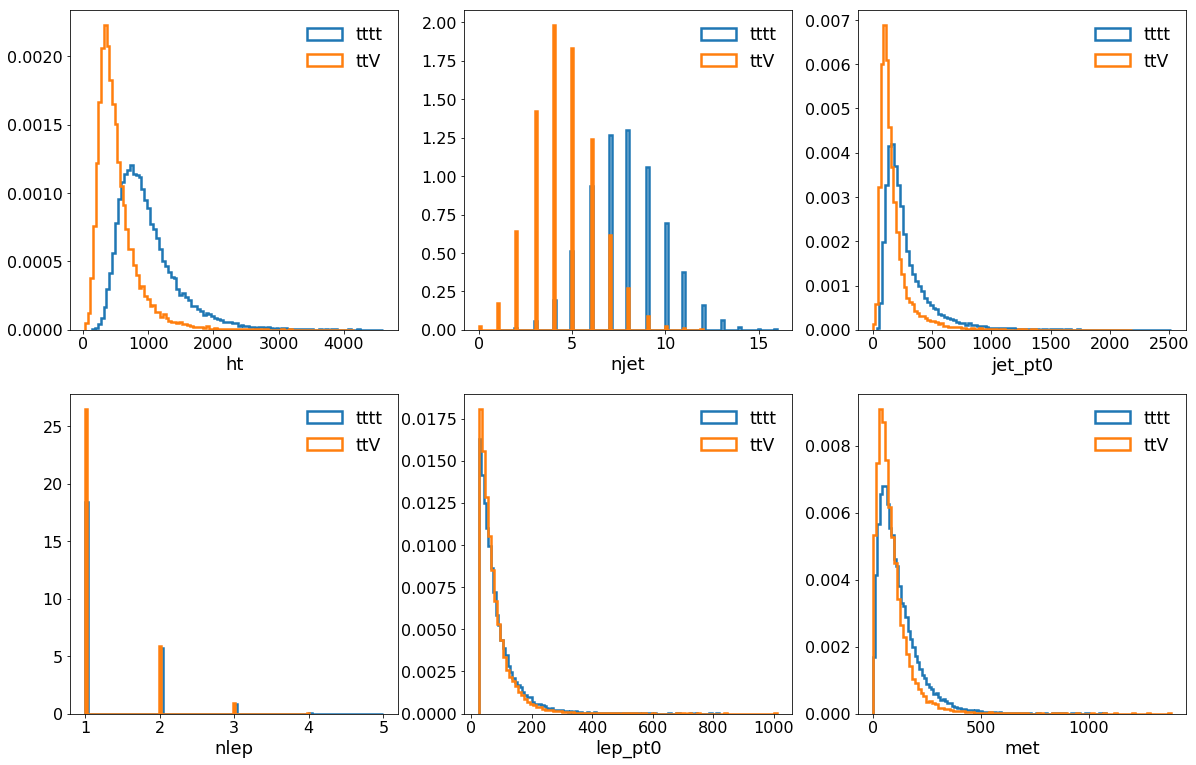

In [9]:
compare_4top_ttV_distributions(df,df_ttV,['ht','njet','jet_pt0','nlep','lep_pt0','met'],'nlep>0')

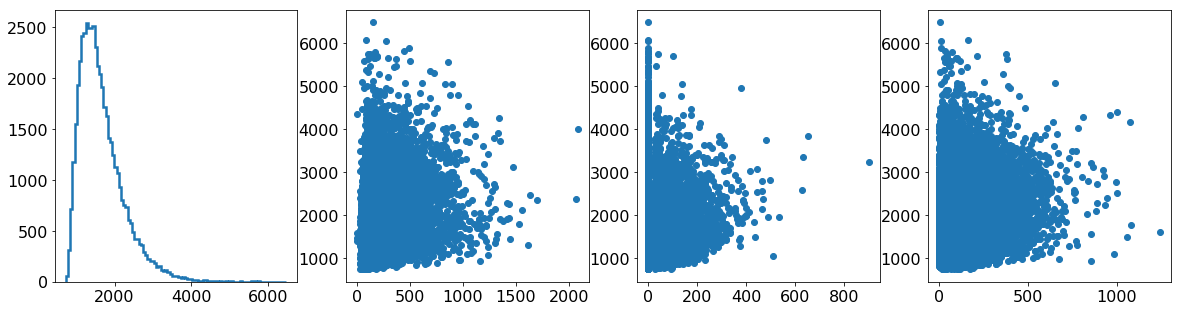

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.hist(df['m4top'], bins=100, histtype='step', linewidth=2.5,label='tttt')
plt.subplot(142)
plt.scatter(df['jet_pt1'],df['m4top'])
plt.subplot(143)
plt.scatter(df['lep_pt1'],df['m4top'])
plt.subplot(144)
plt.scatter(df['met'],df['m4top'])

In [11]:
# Features and target
dataX = df.drop('m4top',axis=1)
dataY = df['m4top']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

In [12]:
rf_regre = RandomForestRegressor(n_estimators=100,n_jobs=-1,max_depth=10).fit(trainX, trainY)

In [13]:
from sklearn.ensemble    import AdaBoostRegressor
from sklearn.tree        import DecisionTreeRegressor
ab_regre = AdaBoostRegressor(n_estimators=10, base_estimator=DecisionTreeRegressor(max_depth=10)).fit(trainX, trainY)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regre = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=10).fit(trainX,trainY)

In [15]:
#from xgboost.sklearn import XGBClassifier
#xgb_regre = XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=10).fit(trainX,trainY)
# --> eat too much memory and I am not sure why ...

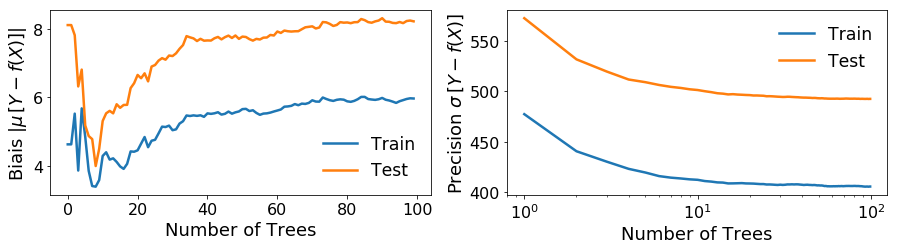

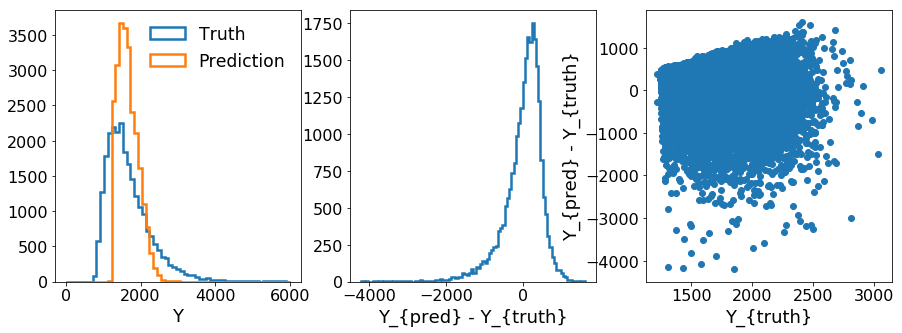

In [16]:
plot_perf_randomforest_vs_ntree(rf_regre,trainX,trainY,testX,testY)
plot_prediction_vs_truth(rf_regre,testX,testY)

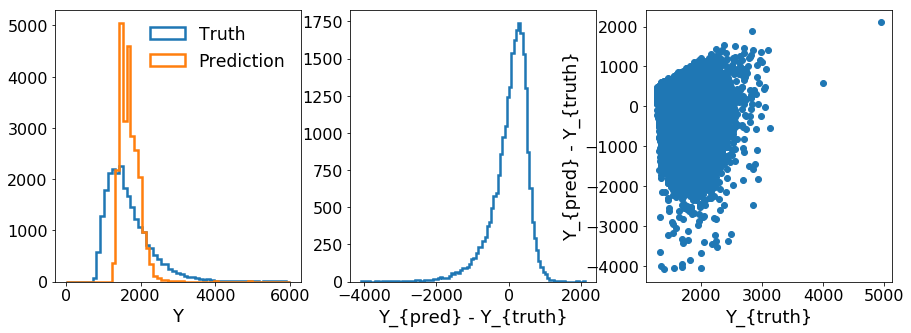

In [17]:
plot_prediction_vs_truth(ab_regre,testX,testY)

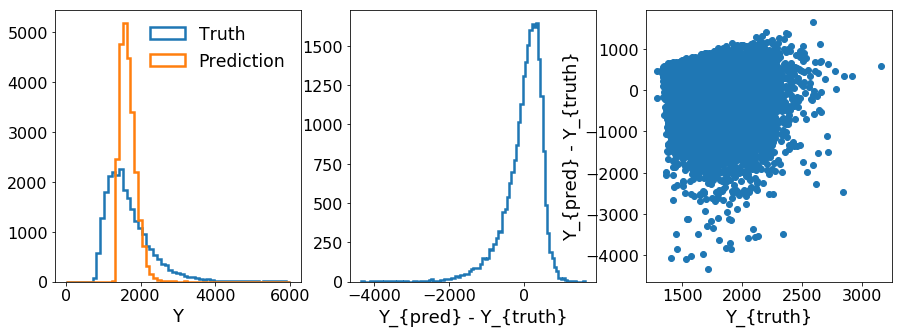

In [18]:
plot_prediction_vs_truth(gb_regre,testX,testY)

In [19]:
#plot_prediction_vs_truth(xgb_regre,testX,testY)

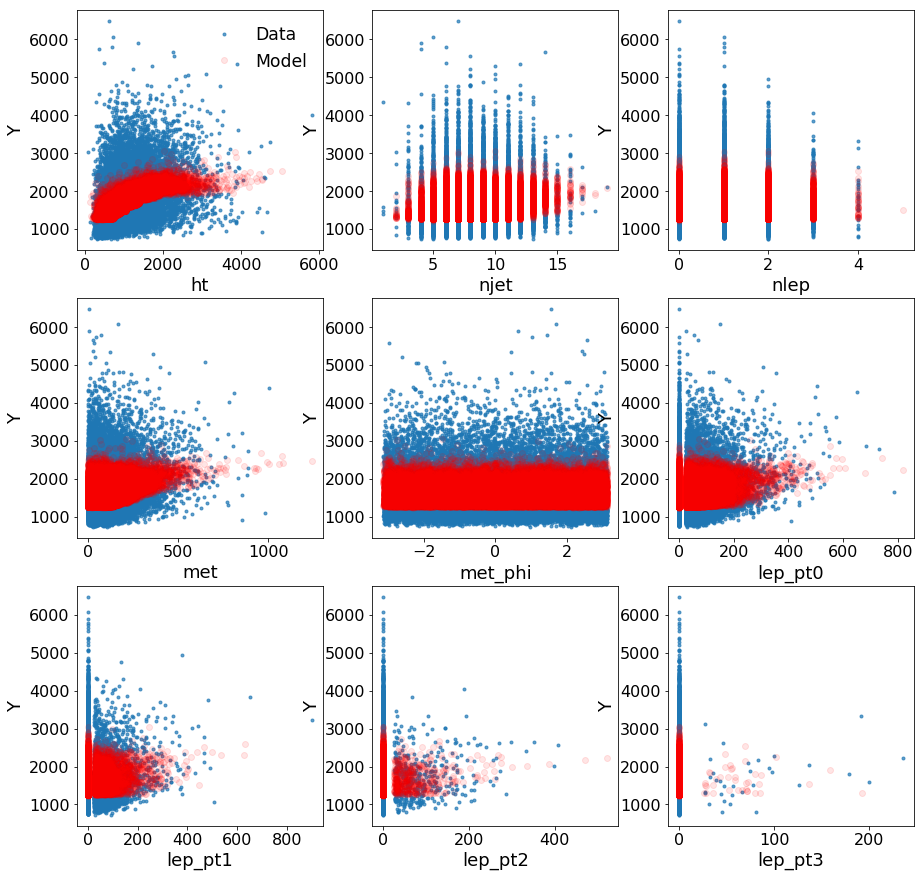

In [20]:
plot_prediction_ndim(rf_regre,testX,testY,trainX,trainY)

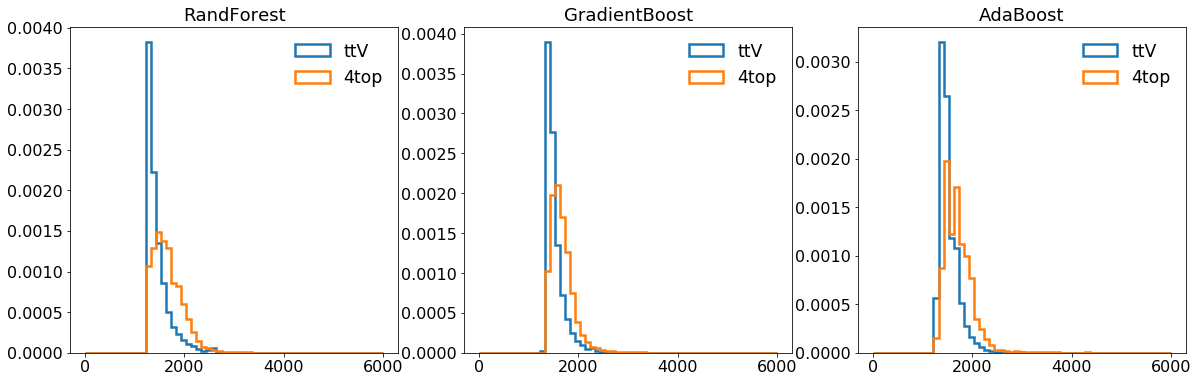

In [21]:
plt.figure(figsize=(20,6))
regressors=[[rf_regre,'RandForest'],[gb_regre,'GradientBoost'],[ab_regre,'AdaBoost']]
dataX_ttV = df_ttV.drop('m4top',axis=1)

i=0
for regre,name in regressors:
    i=i+1
    plt.subplot(1,3,i)
    plt.hist(regre.predict(dataX_ttV), density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='ttV')
    plt.hist(regre.predict(trainX)   , density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='4top')
    plt.title(name)
    plt.legend()

In [22]:
# Try classification
sig_labelled = df.drop(['m4top'],axis=1)
sig_labelled['isSig'] = 1
bkg_labelled = df_ttV.drop(['m4top'],axis=1)
bkg_labelled['isSig'] = 0
data  = pd.concat( [sig_labelled,bkg_labelled] )
dataX_clf = data.drop('isSig',axis=1)
dataY_clf = data['isSig']

#dataX_clf = dataX_clf[['ht','met','lep_pt3','jet_pt1','jet_pt6']]

# Preparing cross validation samples
trainX_clf, testX_clf, trainY_clf, testY_clf = train_test_split(dataX_clf, dataY_clf, random_state=42, train_size=0.5)

In [23]:
rf_clf = RandomForestRegressor(n_estimators=200,n_jobs=-1,max_depth=15).fit(trainX_clf, trainY_clf)

In [25]:
# look at the features importance
for feature, importance in zip(trainX_clf.columns,rf_clf.feature_importances_):
    if (importance>0.01):
        print (feature, importance)

ht 0.124697403057
met 0.0849376283686
met_phi 0.0135765274706
lep_pt0 0.0292885086282
jet_pt0 0.0134535212437
jet_pt1 0.0115548278212
jet_pt2 0.0132186130903
jet_pt3 0.0145426418517
jet_pt4 0.0190288624267
jet_pt5 0.0272575859579
jet_pt6 0.38274264034
jet_pt7 0.0123204834031
jet_pt8 0.0159117613053
jet_pt9 0.0114906581885
jet_eta0 0.0133105524621
jet_eta1 0.0131401637072
jet_eta2 0.0127505085943
jet_eta3 0.0135002102358
jet_eta4 0.0121952190337
jet_eta5 0.0104169935633
jet_phi0 0.0130513395777
jet_phi1 0.0136399027635
jet_phi2 0.0137994646273
jet_phi3 0.0140352061895
jet_phi4 0.0126803551278


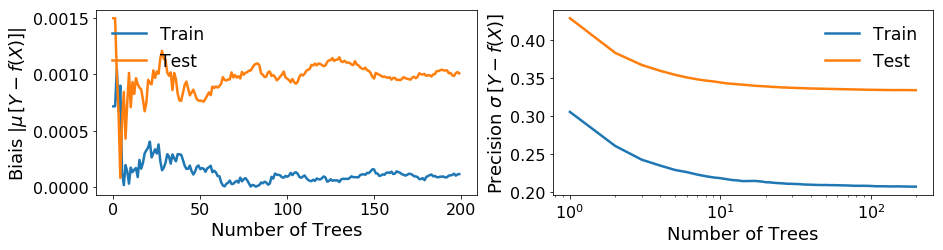

In [26]:
plot_perf_randomforest_vs_ntree(rf_clf,trainX_clf,trainY_clf,testX_clf,testY_clf)

Text(0.5,0,'Prediction of IsSignal')

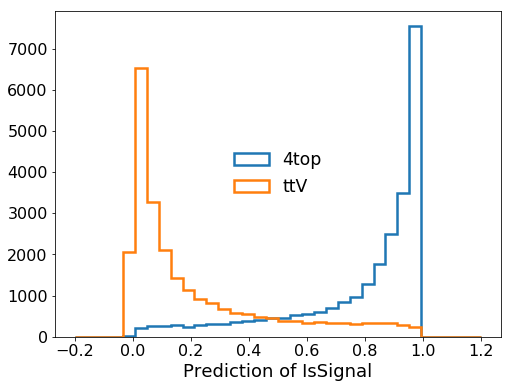

In [27]:
plt.figure(figsize=(8,6))
plt.hist(rf_clf.predict(testX_clf[testY_clf==1]), histtype='step', bins=np.linspace(-0.2,1.2,35), linewidth=2.5, label='4top')
plt.hist(rf_clf.predict(testX_clf[testY_clf==0]), histtype='step', bins=np.linspace(-0.2,1.2,35), linewidth=2.5, label='ttV')
plt.legend(loc='center')
plt.xlabel('Prediction of IsSignal')

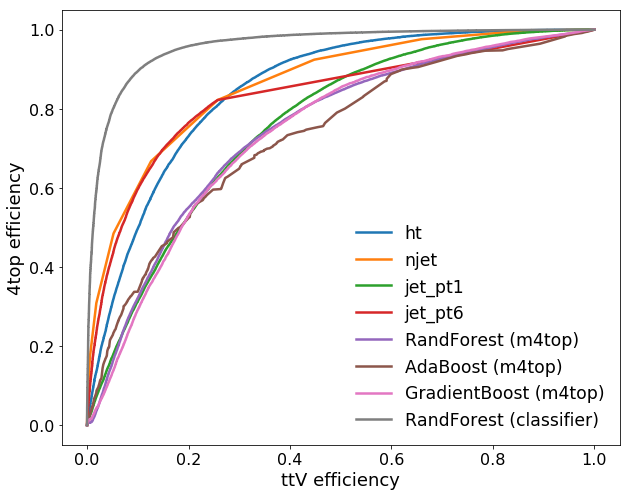

In [29]:
VariableToTest   = ['ht','njet','jet_pt1','jet_pt6']
RegressorsToTest = [[rf_regre,'RandForest (m4top)'],[ab_regre,'AdaBoost (m4top)'],[gb_regre,'GradientBoost (m4top)'],[rf_clf,'RandForest (classifier)']]
plot_roc_curves(df.drop('m4top',axis=1),df_ttV.drop('m4top',axis=1), VariableToTest, RegressorsToTest)